In [14]:
import warnings

import numpy as np
import pyart
from matplotlib import pyplot as plt
import cftime

import radar_codes
import filtering
import phase
import hydrometeors
import attenuation
import rainrate
import file_util
warnings.simplefilter('ignore')


In [15]:
rf_root = '/g/data/kl02/jss548/PST/polarimetric_rain/rf3_instant_rainrate'

# test_vol = '/g/data/rq0/level_1/odim_pvol_sync/2/20200613/2_20200613_121800.pvol.h5' #S band
# radar_id = 2

# test_vol = '/g/data/rq0/level_1/odim_pvol_sync/2/20200519/2_20200519_150600.pvol.h5' #S band
# radar_id = 2

# test_vol = '/g/data/rq0/level_1/odim_pvol_sync/95/20200519/95_20200519_112400.pvol.h5' #C band - Rainbow
# radar_id = 95

test_vol = '/g/data/rq0/level_1/odim_pvol_sync/31/20200505/31_20200505_094800.pvol.h5' #C band - Albany
radar_id = 31

climatology_root = '/g/data/rq0/admin/RF3_climatology'

In [16]:
radar = pyart.aux_io.read_odim_h5(test_vol, file_field_names=True)
wavelength = radar_codes.get_wavelength(test_vol)
if wavelength<8:
    band = 'C'
else:
    band = 'S'
print(band)

C


In [17]:
# Correct RHOHV
rho_corr = radar_codes.correct_rhohv(radar, snr_name='SNRH')
radar.add_field_like('RHOHV', 'RHOHV_CORR', rho_corr, replace_existing=True)

# Correct ZDR
corr_zdr = radar_codes.correct_zdr(radar, snr_name='SNRH')
radar.add_field_like('ZDR', 'ZDR_CORR', corr_zdr, replace_existing=True)

# Temperature    
height, temperature, isom = radar_codes.temperature_profile_access(radar)
radar.add_field('temperature', temperature, replace_existing=True)
radar.add_field('height', height, replace_existing=True)
radar.add_field('height_over_isom', isom, replace_existing=True)

# GateFilter
gatefilter = filtering.do_gatefilter(radar,
                                     refl_name='DBZH',
                                     phidp_name="PHIDP",
                                     rhohv_name='RHOHV_CORR',
                                     zdr_name="ZDR_CORR",
                                     snr_name='SNRH')
#create fake NCP
ncp = pyart.config.get_metadata('normalized_coherent_power')
ncp['data'] = np.zeros_like(radar.fields['RHOHV']['data'])
ncp['data'][gatefilter.gate_included] = 1
radar.add_field('NCP', ncp, replace_existing=True)

# phidp filtering
phidp, kdp = phase.phidp_giangrande(radar, gatefilter, rhv_field='RHOHV_CORR', refl_field='DBZH')
#phidp, kdp = phase.phidp_bringi(radar, gatefilter, phidp_field='PHIDP', refl_field='DBZH')
radar.add_field('PHIDP_VAL', phidp, replace_existing=True)
radar.add_field('KDP_VAL', kdp, replace_existing=True)
kdp_field_name = 'KDP_VAL'
phidp_field_name = 'PHIDP_VAL'

# Hydrometeors classification
hydro_class = hydrometeors.hydrometeor_classification(radar,
                                                      gatefilter,
                                                      kdp_name=kdp_field_name,
                                                      zdr_name='ZDR_CORR',
                                                      rhohv_name='RHOHV_CORR',
                                                      refl_name='DBZH',
                                                      band=band)
radar.add_field('radar_echo_classification', hydro_class, replace_existing=True)


In [21]:
from importlib import reload
reload(rainrate)
reload(attenuation)

#init alpha dictcontinous
alpha_dict = {'z_pairs':[], 'zdr_pairs':[], 'alpha_ts':[], 'dt_ts':[]}

#estimate alpha
alpha_dict = attenuation.estimate_alpha_wang2019(radar, alpha_dict, band,
                                       refl_field='DBZH', zdr_field='ZDR_CORR', rhohv_field='RHOHV_CORR')

#estimate specific attenuation
alpha = alpha_dict['alpha_ts'][-1]
print(alpha)
radar = attenuation.retrieve_zphi(radar, band, alpha=alpha,
                                 refl_field='DBZH', phidp_field=phidp_field_name, rhohv_field='RHOHV_CORR')

#load beam blockage
climatology_ffn = f'{climatology_root}/{radar_id}_climatology.vol.h5'
climatology = pyart.aux_io.read_odim_h5(climatology_ffn, file_field_names=True)
climatology.check_field_exists('BEAMB')
beamb_data = climatology.fields['BEAMB']['data'].copy()

#estimate rainfall
radar = rainrate.conventional(radar, alpha=92, beta=1.7, refl_field='corrected_reflectivity')
radar = rainrate.polarimetric(radar, band, refl_field='corrected_reflectivity', beamb_data=beamb_data, kdp_field=kdp_field_name, rhohv_field='RHOHV_CORR')


0.000980819141352341 0.05704714584976933 0.08156762438357786 0.2 10.322011598549725
34801 pairs found, finding Z-ZDR slope
slope value 0.05377730341518624
alpha value 0.08156762438357786
0.08156762438357786


(25.0, 75.0)

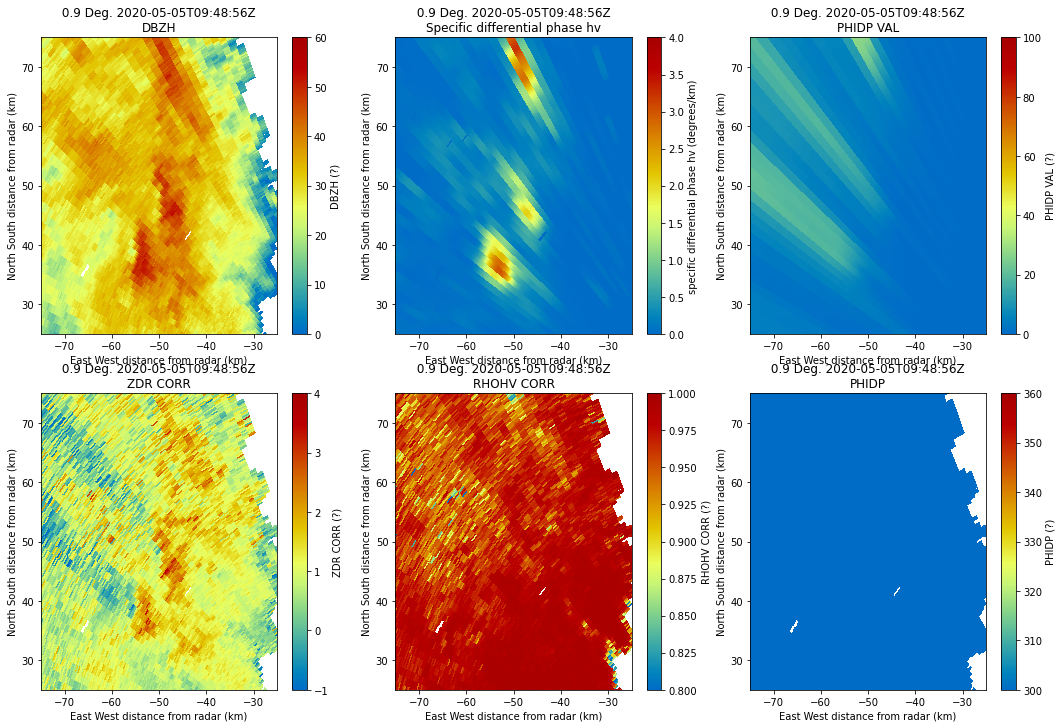

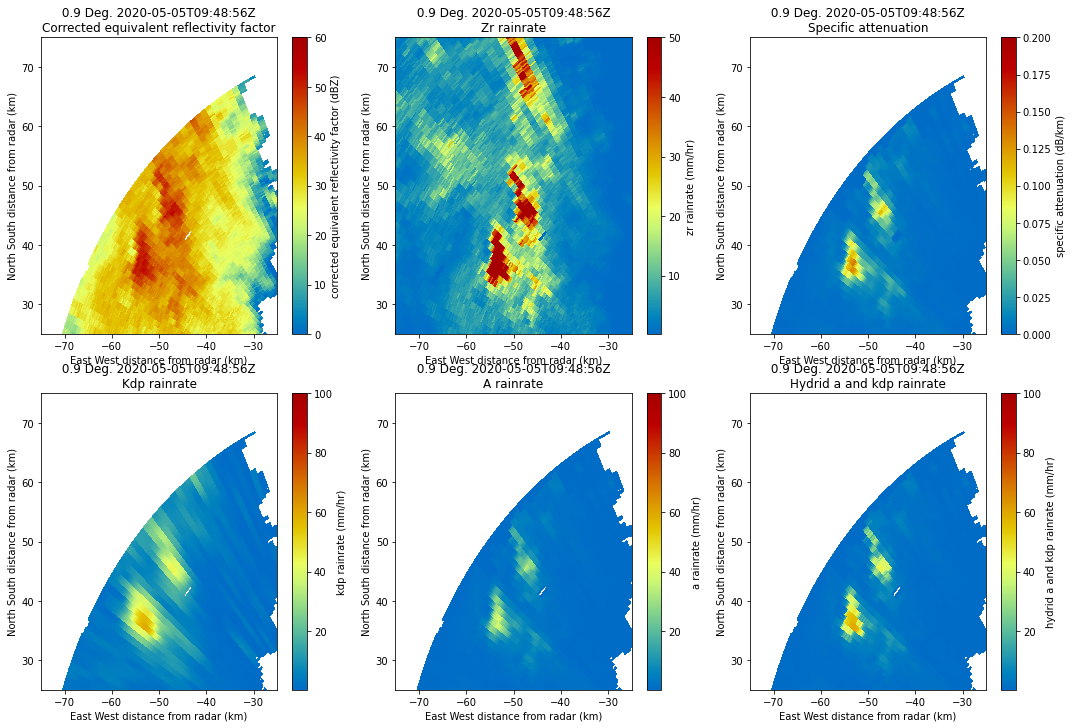

In [28]:
#corrected DBZH for rainfall

tilt = 1
ylim = [25, 75]
xlim = [-75, -25]
# ylim = [25, 50]
# xlim = [-70, -30]

#restore hail pixels
pid = radar.fields['radar_echo_classification']['data']
gatefilter.include_gates(pid==9)

###################################################################################################################

fig = plt.figure(figsize=[18,12])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(231)
display.plot_ppi('DBZH', tilt, vmin=0, vmax=60, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(232)
display.plot_ppi('KDP_VAL', tilt, vmin=0, vmax=4, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(233)
display.plot_ppi('PHIDP_VAL', tilt, vmin=0, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(234)
display.plot_ppi('ZDR_CORR', tilt, vmin=-1, vmax=4, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax = plt.subplot(235)
display.plot_ppi('RHOHV_CORR', tilt, vmin=0.8, vmax=1, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(236)
display.plot_ppi('PHIDP', tilt, vmin=300, vmax=360, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

###################################################################################################################

fig = plt.figure(figsize=[18,12])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(231)
display.plot_ppi('corrected_reflectivity', tilt, vmin=0, vmax=60, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(232)
display.plot_ppi('zr_rainrate', tilt, vmin=0.2, vmax=50, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(233)
display.plot_ppi('specific_attenuation', tilt, vmin=0.0, vmax=0.2, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(234)
display.plot_ppi('kdp_rainrate', tilt, gatefilter=gatefilter, vmin=0.2, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(235)
display.plot_ppi('ah_rainrate', tilt, gatefilter=gatefilter, vmin=0.2, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(236)
display.plot_ppi('hybrid_rainrate', tilt, gatefilter=gatefilter, vmin=0.2, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# ###################################################################################################################

# fig = plt.figure(figsize=[12,5])
# display = pyart.graph.RadarDisplay(radar)

# ax = plt.subplot(131)
# display.plot_ppi('zr_rainrate', tilt, vmin=0.5, vmax=100, cmap='pyart_HomeyerRainbow')

# ax = plt.subplot(132)
# display.plot_ppi('ah_a_array', tilt, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow', title='R(A) a parameter')

# ax = plt.subplot(133)
# display.plot_ppi('ah_b_array', tilt, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow', title='R(A) b parameter')



In [9]:
#grid RF
GRID_SHAPE = (6, 512, 512)
GRID_LIMITS = ((0, 2500), (-128000.0, 128000.0), (-128000.0, 128000.0))
GRID_ROI = 1000
hydrid_gatefilter = pyart.correct.GateFilter(radar)
hydrid_gatefilter.exclude_masked('hybrid_rainrate')
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
standard_lat_1 = radar_lat+1.0
standard_lat_2 = radar_lat-1.0
grid_proj ={'proj':'aea', 'lat_1':standard_lat_1, 'lat_2':standard_lat_2,
           'lon_0':radar_lon, 'lat_0':radar_lat}
rf_grid = pyart.map.grid_from_radars(
                radar,
                grid_shape = (6, 512, 512),
                grid_limits = ((0, 2500), (-128000.0, 128000.0), (-128000.0, 128000.0)),
                roi_func = 'constant',
                grid_projection = grid_proj,
                gatefilter = hydrid_gatefilter,
                constant_roi = 2500,
                weighting_function = 'Barnes2',
                fields = ['hybrid_rainrate'])

#extract lowest valid values
rain_grid = rf_grid.fields['hybrid_rainrate']['data']
rain_grid_mask = np.ma.getmaskarray(rain_grid)

rain_grid_2d = np.zeros((GRID_SHAPE[1],GRID_SHAPE[2]))
for i in range(GRID_SHAPE[1]):
    for j in range(GRID_SHAPE[2]):
        col_rain = rain_grid[:,i,j]
        mask = ~np.ma.getmaskarray(col_rain)
        if np.any(mask):
            rain_grid_2d[i,j] = col_rain[np.where(mask)[0][0]]

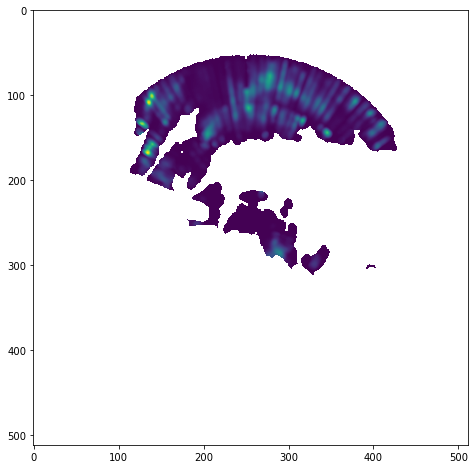

In [48]:
fig = plt.figure(figsize=(8,8))
plt.imshow(rain_grid[2,:,:])

In [56]:
"""
Generates output netcdf files
"""

import os

valid_time = cftime.num2pydate(radar.time['data'][0], radar.time['units'])
# generate output filename
date_str = '20200613'
vol_ffn = '2_20200613_121800.pvol.h5'

rf_path = f'{rf_root}/{radar_id:02}/{date_str}'
if not os.path.exists(rf_path):
    os.makedirs(rf_path)
rf_fn = f'{radar_id}_{valid_time.strftime("%Y%m%d_%H%M%S")}.prcp-rrate.nc' #this filename should match
rf_ffn = f'{rf_path}/{rf_fn}'

print(rf_fn)
#get time

file_util.write_rf_nc(rf_ffn, radar_id, valid_time.timestamp(), rain_grid_2d, radar_lon, radar_lat, (standard_lat_1, standard_lat_2))


2_20200613_121831.prcp-rrate.nc


In [3]:
from datetime import datetime

new_dt = datetime.now()